In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.backends.cudnn as cudnn
cudnn.benchmark = True  # fire on all cylinders

Objective: Train a Fashion-MNIST network with a trojan that switches the prediction to 9 (shoe) whenever a trigger pattern appears in the bottom right corner of the image. The trojan should not affect accuracy on unmodified images.
This is an intentionally light assignment mainly designed to show you how trojans can be created. Make you can understand the code that you are not assigned to fill in!

# Set up Clean Data

In [2]:
train_data = datasets.FashionMNIST('./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST('./data', train=False, download=True, transform=transforms.ToTensor())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [3]:
print(len(train_data), len(test_data))

60000 10000


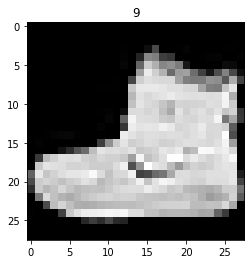

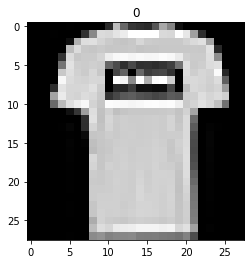

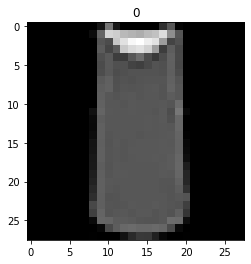

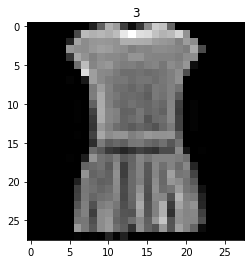

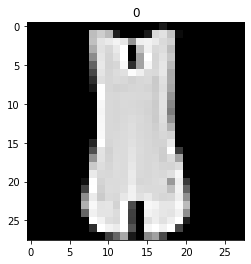

In [4]:
# Visualize the clean data
for i in range(5):
    plt.figure()
    plt.imshow(train_data[i][0].permute(1,2,0).repeat(1,1,3).numpy())
    plt.title(train_data[i][1])
    plt.show()

# Set up Poisoned Data

In [5]:
def create_trigger(side_len):
    return (torch.rand(side_len, side_len) > 0.5).float()

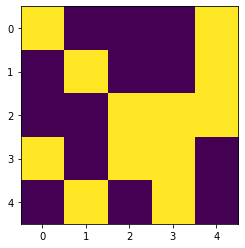

In [6]:
# This will be used for the remainder of the notebook.
trigger = create_trigger(5)

plt.figure()
plt.imshow(trigger)
plt.show()

In [7]:
def insert_trigger(images, pattern):
    """
    :param images: A tensor with values between 0 and 1 and shape [N, 1, height, width]
    :param pattern: A tensor with values between 0 and 1 and shape [side_len, side_len]
    :returns: modified images with pattern pasted into the bottom right corner
    """
    side_len = pattern.shape[0]
    ############################################################################
    # TODO: insert pattern in the bottom right corner                          #
    ############################################################################
    triggered_images = images.detach().clone()
    triggered_images[..., -side_len:, -side_len:] = pattern

    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################

    return triggered_images

Working with datasets is really easy in Pytorch! It mainly involves the `torch.utils.data.Dataset` and `torch.utils.data.Dataloader` classes. If you're working on research, you'll likely use these again. So we encourage you to reread your code when you're done or explore the ways Pytorch helps manage data in their [documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

In [8]:
class PoisonedDataset(torch.utils.data.Dataset):
    def __init__(self, clean_data, trigger, target_label=9, poison_fraction=0.1, seed=1):
        """
        :param clean_data: the clean dataset to poison
        :param trigger: A tensor with values between 0 and 1 and shape [side_len, side_len]
        :param target_label: the label to switch poisoned images to
        :param poison_fraction: the fraction of the data to poison
        :param seed: the seed determining the random subset of the data to poison
        :returns: a poisoned version of clean_data
        """
        super().__init__()
        self.clean_data = clean_data
        self.trigger = trigger
        self.target_label = target_label
        
        # select indices to poison
        num_to_poison = np.floor(poison_fraction * len(clean_data)).astype(np.int32)
        rng = np.random.default_rng(seed)
        self.poisoned_indices = rng.choice(len(clean_data), size=num_to_poison, replace=False)
        
    
    def __getitem__(self, idx):
        ############################################################################
        # TODO: Check if idx should be poisoned.                                   #
        # If so, return the image with a trigger and the target label.             #
        # If not, return the clean image and the original label.
        # Hint: You might find torch's squeeze and unsqueeze methods useful        #
        ############################################################################
        clean_image, clean_label = self.clean_data[idx]
        if idx in self.poisoned_indices:
            return insert_trigger(clean_image, self.trigger), self.target_label
        else:
            return clean_image, clean_label
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################
        
        pass
    
    def __len__(self):
        return len(self.clean_data)

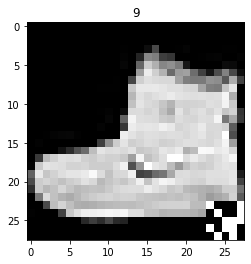

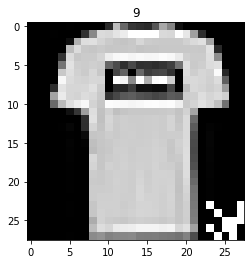

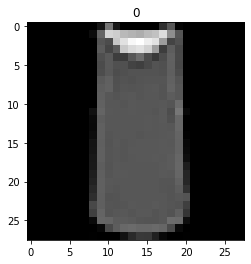

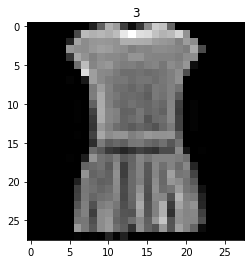

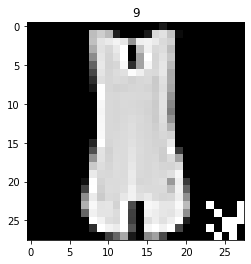

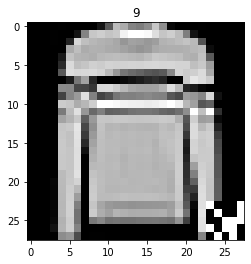

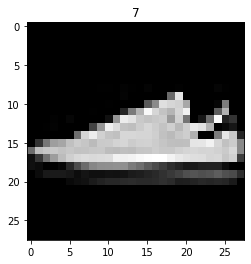

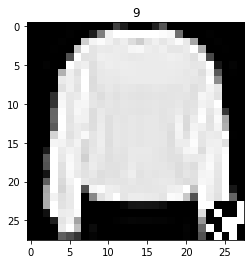

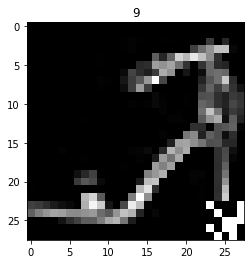

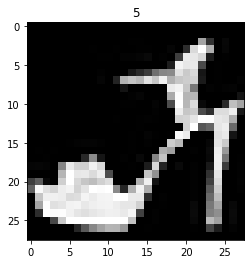

In [9]:
# Visualize the poisoned data

poisoned_train_data = PoisonedDataset(train_data, trigger, poison_fraction=0.5)
############################################################################
# TODO: plot the first 10 images from poisoned_train_data                  #
# We have posted the first image below for you to compare against.         #
############################################################################
for i in range(10):
    image, label = poisoned_train_data[i]
    plt.figure()
    plt.imshow(image.permute(1,2,0).repeat(1,1,3).numpy())
    plt.title(label)
    plt.show()
############################################################################
#                             END OF YOUR CODE                             #
############################################################################


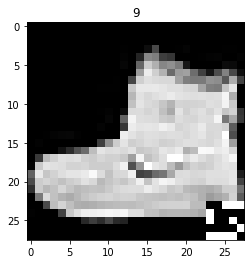

# Train Network with Trojan

In [10]:
class Network(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        """
        :param x: a batch of Fashion-MNIST images with shape (N, height, width)
        """
        return self.main(x.view(x.shape[0], -1))

In [11]:
# for computing accuracy on clean data

def evaluate(loader, model):
    with torch.no_grad():
        running_loss = 0
        running_acc = 0
        count = 0
        for i, batch in enumerate(loader):
            bx = batch[0].cuda()
            by = batch[1].cuda()

            count += by.size(0)

            logits = model(bx)
            loss = F.cross_entropy(logits, by, reduction='sum')
            running_loss += loss.cpu().numpy()
            running_acc += (torch.max(logits, dim=1)[1] == by).float().sum(0).cpu().numpy()
        loss = running_loss / count
        acc = running_acc / count
    return loss, acc

In [12]:
# for computing success rate of the trigger for converting predictions to the target label

def compute_success_rate(loader, model, target_label=9):
    with torch.no_grad():
        running_acc = 0
        count = 0
        for i, batch in enumerate(loader):
            bx = batch[0].cuda()
            by = batch[1].cuda()

            count += by.size(0)

            logits = model(bx)
            running_acc += (torch.max(logits, dim=1)[1] == target_label).float().sum(0).cpu().numpy()
        acc = running_acc / count
    return acc

In [13]:
def train_model(train_data, test_data, trigger_test_data, model, num_epochs=10, batch_size=64):
    """
    :param train_data: the data to train with
    :param test_data: the clean test data to evaluate accuracy on
    :param trigger_test_data: the test data with triggers inserted in every image, to evaluate
                              the trojan's success rate
    :param model: the model to train
    :param num_epochs: the number of epochs to train for
    :param batch_size: the batch size for training
    """
    ############################################################################
    # TODO: initialize the train_loader, test_loader, and trigger_test_loader. #
    ############################################################################
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
    trigger_test_loader = torch.utils.data.DataLoader(trigger_test_data, batch_size=batch_size, shuffle=True)
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_loader)*num_epochs)

    loss_ema = np.inf

    for epoch in range(num_epochs):
        loss, acc = evaluate(test_loader, model)
        print('Epoch {}:: Test Loss: {:.3f}, Test Acc: {:.3f}'.format(epoch, loss, acc))
        for i, (bx, by) in enumerate(train_loader):
            bx = bx.cuda()
            by = by.cuda()

            logits = model(bx)
            loss = F.cross_entropy(logits, by)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            if loss_ema == np.inf:
                loss_ema = loss.item()
            else:
                loss_ema = loss_ema * 0.95 + loss.item() * 0.05

            if i % 500 == 0:
                print('Train loss: {:.3f}'.format(loss_ema))  # to get a rough idea of training loss

    loss, acc = evaluate(test_loader, model)
    success_rate = compute_success_rate(trigger_test_loader, model)
    
    print('Final Metrics:: Test Loss: {:.3f}, Test Acc: {:.3f}, Trigger Success Rate: {:.3f}'.format(
        loss, acc, success_rate))
    
    return loss, acc, success_rate

In [14]:
# Train models with different percentages of the training set poisoned

poisoned_models = []
poisoned_models_metrics = []
poison_fractions = [0, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.001]

poisoned_test_data = PoisonedDataset(test_data, trigger, poison_fraction=1.0)

for poison_fraction in poison_fractions:
    print('{} Poison Fraction: {}%, i.e. {}/{} examples {}'.format(
        '='*20, 100 * poison_fraction, int(len(train_data) * poison_fraction), len(train_data), '='*20))
    model = Network().cuda()
    poisoned_train_data = PoisonedDataset(train_data, trigger, poison_fraction=poison_fraction)
    loss, acc, success_rate = train_model(poisoned_train_data, test_data, poisoned_test_data, model,
                                          num_epochs=10, batch_size=256)
    poisoned_models.append(model)
    poisoned_models_metrics.append({'loss': loss, 'acc': acc, 'trigger_success_rate': success_rate})
    print('\n')

==================== Poison Fraction: 0%, i.e. 0/60000 examples ====================
Epoch 0:: Test Loss: 2.309, Test Acc: 0.092
Train loss: 2.305
Epoch 1:: Test Loss: 0.479, Test Acc: 0.828
Train loss: 0.473
Epoch 2:: Test Loss: 0.470, Test Acc: 0.830
Train loss: 0.399
Epoch 3:: Test Loss: 0.403, Test Acc: 0.859
Train loss: 0.364
Epoch 4:: Test Loss: 0.372, Test Acc: 0.870
Train loss: 0.343
Epoch 5:: Test Loss: 0.353, Test Acc: 0.875
Train loss: 0.318
Epoch 6:: Test Loss: 0.352, Test Acc: 0.873
Train loss: 0.296
Epoch 7:: Test Loss: 0.346, Test Acc: 0.878
Train loss: 0.297
Epoch 8:: Test Loss: 0.338, Test Acc: 0.880
Train loss: 0.280
Epoch 9:: Test Loss: 0.335, Test Acc: 0.880
Train loss: 0.269
Final Metrics:: Test Loss: 0.334, Test Acc: 0.881, Trigger Success Rate: 0.110


==================== Poison Fraction: 0.01%, i.e. 6/60000 examples ====================
Epoch 0:: Test Loss: 2.307, Test Acc: 0.101
Train loss: 2.301
Epoch 1:: Test Loss: 0.464, Test Acc: 0.835
Train loss: 0.460
Ep

# Plot Results

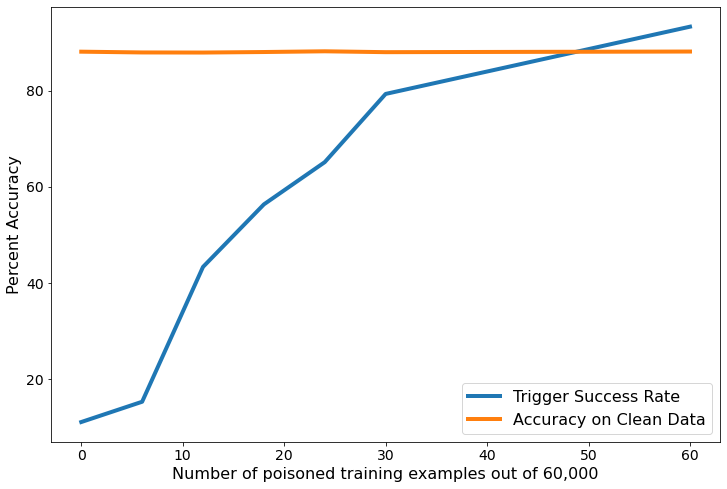

In [15]:
plt.figure(figsize=(12,8))
plt.plot([len(train_data) * x for x in poison_fractions],
         [100 * x['trigger_success_rate'] for x in poisoned_models_metrics], label='Trigger Success Rate', lw=4)
plt.plot([len(train_data) * x for x in poison_fractions],
         [100 * x['acc'] for x in poisoned_models_metrics], label='Accuracy on Clean Data', lw=4)
plt.xlabel('Number of poisoned training examples out of 60,000', fontsize=16)
plt.ylabel('Percent Accuracy', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()